In [993]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

data_stud = pd.read_csv("Mid_day_meal.csv",sep="\t")

data_stud.Date = pd.to_datetime(data_stud["Date"])

data_stud = data_stud.set_index(data_stud.Date)

data_stud = data_stud.drop(["Date"],axis=1)

#check for any Nan values
data_stud["students"].isna().sum()



0

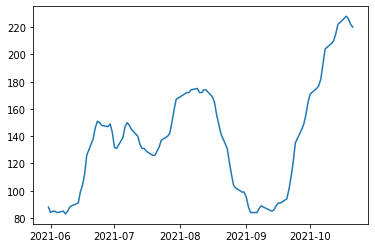

In [994]:
plt.plot(data_stud["students"])


# Analyzing the time series


In [995]:
# To test the statiobnarity of time series
# Dick Fuller Test

result = adfuller(data_stud["students"])
print("ADF statistic", result[0])
print("p-value",result[1])
print("crictical values :")
for key, value in result[4].items():
    print(key,value)

if result[0]<result[4]["5%"]:
    print("reject null hypothesis")
else:
    print("Failed to reject null hypothesis AND Time series non-stationary")
    

ADF statistic -2.4642397172033665
p-value 0.1244193544710952
crictical values :
1% -3.5003788874873405
5% -2.8921519665075235
10% -2.5830997960069446
Failed to reject null hypothesis AND Time series non-stationary


Time series is not stationary; to make it stationary, without changing its properties two formalisms can be adopted,

1.) Differencing 2.) Decomposition


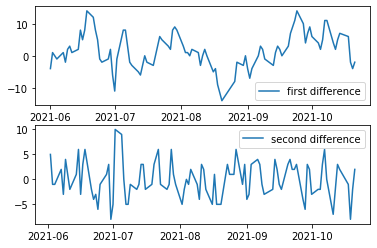

In [996]:
#1.)N-order Differencing
prev_value = data_stud["students"].shift()
#print(data_nse["Close"],prev_value)
diff = data_stud["students"] - prev_value
#diff.plot()

# Alternatively
fig,ax =plt.subplots(2,1)
(ax1,ax2) =ax

diff1 = data_stud["students"].diff().dropna()
diff2 =  diff1.diff().dropna()

ax1.plot(diff1,label="first difference")
ax2.plot(diff2,label="second difference")

ax1.legend(loc="best")
ax2.legend(loc="best")

In [997]:
# Run ADF test with first order differencing

results_new = adfuller(diff1.dropna())
print("new ADF statistic",results_new[0])
print("p value",results_new[1])
print("critical values:")
for key,value in results_new[4].items():
    print(key,value)
if results_new[0] > results_new[4]["5%"]:
    print("Null hypothesis; times series non stationary")
else:
    print("Reject Null hypothesis; series is stationary")

new ADF statistic -2.7222384904429533
p value 0.07026846015272693
critical values:
1% -3.5003788874873405
5% -2.8921519665075235
10% -2.5830997960069446
Null hypothesis; times series non stationary


In [998]:
# Run ADF test again with second order differencing

results_new = adfuller(diff2.dropna())
print("new ADF statistic",results_new[0])
print("p value",results_new[1])
print("critical values:")
for key,value in results_new[4].items():
    print(key,value)
if results_new[0] > results_new[4]["5%"]:
    print("Null hypothesis; times series non stationary")
else:
    print("Reject Null hypothesis; series is stationary")

new ADF statistic -9.929762173626015
p value 2.843428755547158e-17
critical values:
1% -3.5003788874873405
5% -2.8921519665075235
10% -2.5830997960069446
Reject Null hypothesis; series is stationary


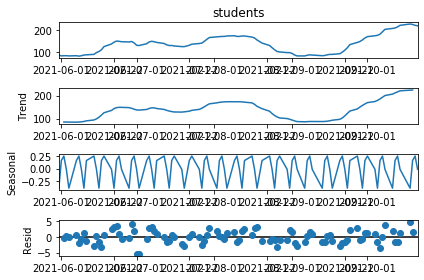

In [999]:
#2.) Decomposition
# De-trend and de-seasonalize the seres
from statsmodels.tsa.seasonal import seasonal_decompose

decom_results = seasonal_decompose(data_stud["students"],model="additive",period=4)
decom_results.plot();



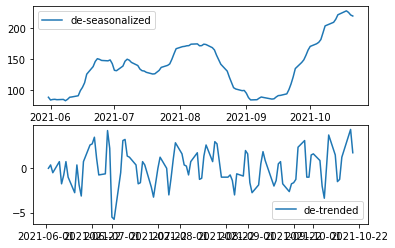

In [1000]:
fig,ax =plt.subplots(2,1)
(ax1,ax2)=ax
detrend = data_stud["students"]-decom_results.trend
deseasonalized =data_stud["students"] - decom_results.seasonal

ax2.plot(detrend,label="de-trended")
ax1.plot(deseasonalized,label="de-seasonalized")

ax1.legend(loc="best")
ax2.legend(loc="best")

The time series is de-trended and de-seasonalize

Finding the order of the AR term (p)

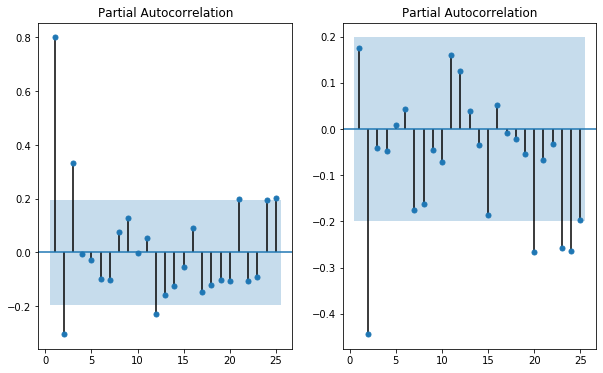

In [1001]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,axs=plt.subplots(1,2,figsize=(10,6))
(ax1),(ax2)=axs

plot_pacf(diff1,lags=25,zero=False,ax=ax1);
plot_pacf(diff2,lags=25,zero=False,ax=ax2);


The ACF plot for the 2nd differencing, the lag = 2 goes into the far negative zone fairly quick, that indicates, the series might have been over differenced.

Therefore, differencing order(d) is tentatively kept as 1 even though it displays weak stationarity.

PACF lag 1,2 and 3 are quite significant since they are well above the statistical confidence threshold 

Finding the order of the MA term (q)

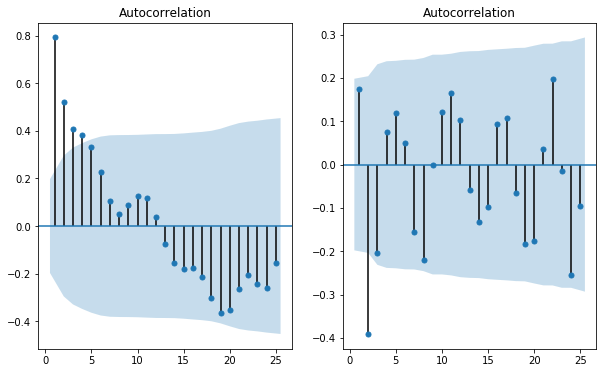

In [1002]:
fig,axs=plt.subplots(1,2,figsize=(10,6))
(ax1),(ax2)=axs

plot_acf(diff1,lags=25,zero=False,ax=ax1);
plot_acf(diff2,lags=25,zero=False,ax=ax2);


ACF lag 1,2 are quite significant since they are  well above the statistical confidence threshold

Building ARIMA model

Now the p, d and q values are known, next step is to fit the ARIMA model 

In [1003]:
from itertools import product
p= q = range(0, 3)
d= range(1,2)
pdq = list(product(p,d,q))

for param in pdq:
    model= ARIMA(data_stud["students"],order=param)
    model_fit = model.fit()
    print("ARIMA with order{} has AIC as {} and BIC as {}".format(param,model_fit.aic,model_fit.bic) )
    

ARIMA with order(0, 1, 0) has AIC as 627.6192143959762 and BIC as 632.8094540962454
ARIMA with order(0, 1, 1) has AIC as 548.1637313328379 and BIC as 555.9490908832416
ARIMA with order(0, 1, 2) has AIC as 519.979009329426 and BIC as 530.3594887299644
ARIMA with order(1, 1, 0) has AIC as 530.8552195035472 and BIC as 538.640579053951
ARIMA with order(1, 1, 1) has AIC as 515.5792067356904 and BIC as 525.9596861362287
ARIMA with order(1, 1, 2) has AIC as 517.5791975560405 and BIC as 530.5547968067134
ARIMA with order(2, 1, 0) has AIC as 523.3140059520074 and BIC as 533.6944853525457
ARIMA with order(2, 1, 1) has AIC as 517.5792051601502 and BIC as 530.5548044108232
ARIMA with order(2, 1, 2) has AIC as 518.7314793568156 and BIC as 534.3021984576231


In [1004]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data_stud["students"],order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.students   No. Observations:                   99
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -253.366
Method:                       css-mle   S.D. of innovations              3.105
Date:                Sat, 04 Jun 2022   AIC                            518.731
Time:                        14:13:15   BIC                            534.302
Sample:                             1   HQIC                           525.031
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0483      1.528      0.686      0.493      -1.947       4.044
ar.L1.D.students     1.1943      0.351      3.403      0.001       0.507       1.882
ar.L2.D.students    -0.3077 

Null hypothesis can not be rejected for AR(2) and MA(1) terms

In [1005]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data_stud["students"],order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.students   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sat, 04 Jun 2022   AIC                            515.579
Time:                        14:13:15   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.students     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.students     0.5297 

Plot the residuals to ensure there are no patterns that is constant mean and variance.

1.) Residual density plot

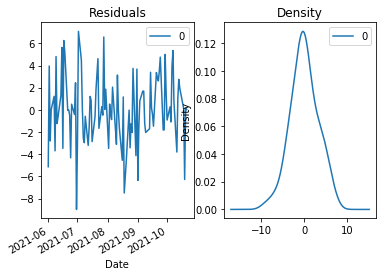

In [1006]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()



2.) QQ-plot

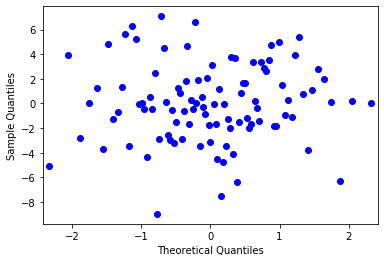

In [1007]:
from statsmodels.graphics.gofplots import qqplot
import numpy as np
residuals = np.array(residuals)
qqplot(residuals)
plt.show()

3.) Residual Autocorrelation plot

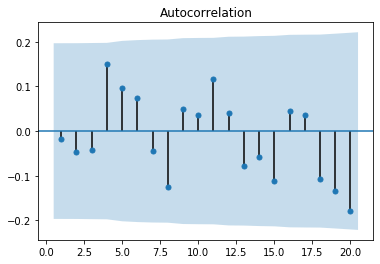

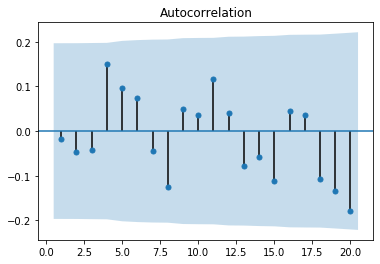

In [1008]:
plot_acf(residuals,zero=False)

No obvious autocorrelation trend can be seen across the plot

# Forecasting


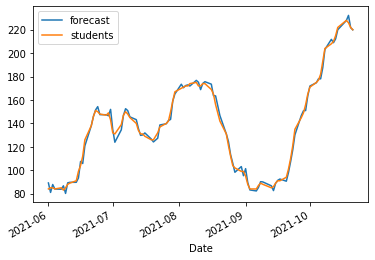

In [1009]:
model_fit.plot_predict();


Optimize ARIMA model manually using Out-of-Time Cross validation

In [1022]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_len =int(0.85*len(data_stud))

train = data_stud[:train_len]
test = data_stud[train_len:]

p=q= range(0,4)
d=range(1,3)

rmse,para,AIC,BIC=[],[],[],[]
pdq_opti = list(product(p,d,q))

train = train.astype('float64')

best_rmse = float("inf")

for parameter in pdq_opti:
    model_Arima_opt = ARIMA(train,order= parameter)
    model_Arima_opt_fit = model_Arima_opt.fit()
    AIC.append(model_Arima_opt_fit.aic)
    BIC.append(model_Arima_opt_fit.bic)
    
    fc_n, se, confid = model_Arima_opt_fit.forecast(len(test), alpha=0.05)
    forecast = pd.Series(fc_n,index=test.index)
    para.append(parameter)
    rmse.append(sqrt(mean_squared_error(test,fc_n)))

print("Optimization of ARIMA:")
print("Order {0} with minimum AIC as: {1:.3f} xxxxxxx Order {2} with minimum BIC as: {3:.3f}".format(para[AIC.index(min(AIC))],min(AIC),para[BIC.index(min(BIC))],min(BIC)))
print("Order {0} with minimum rmse {1:.3f} with values of AIC as {2:.3f} and BIC as {3:.3f}".format(para[rmse.index(min(rmse))],min(rmse),AIC[rmse.index(min(rmse))],BIC[rmse.index(min(rmse))]    )             )
 


Optimization of ARIMA:
Order (2, 2, 0) with minimum AIC as: 439.922 xxxxxxx Order (2, 2, 0) with minimum BIC as: 449.597
Order (3, 2, 2) with minimum rmse 5.403 with values of AIC as 442.333 and BIC as 459.265


                             ARIMA Model Results                              
Dep. Variable:            D2.students   No. Observations:                   83
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -214.166
Method:                       css-mle   S.D. of innovations              3.148
Date:                Sat, 04 Jun 2022   AIC                            442.333
Time:                        14:46:52   BIC                            459.265
Sample:                             2   HQIC                           449.135
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0436      0.081      0.539      0.590      -0.115       0.202
ar.L1.D2.students     1.0113      0.325      3.112      0.002       0.374       1.648
ar.L2.D2.students    -0.

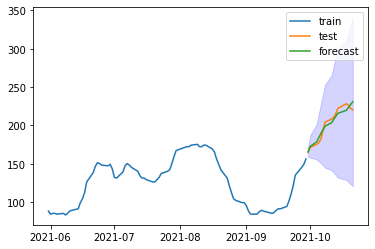

In [1023]:
model_arima =ARIMA(train,order=(3,2,2))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

# Forecast
fc, se, confid = model_arima_fit.forecast(len(test), alpha=0.05)  

# Making a pandas series

fc_series = pd.Series(fc,index=test.index)
lowconf_series = pd.Series(confid[:,0],index=test.index)
uppconf_series = pd.Series(confid[:,1],index=test.index)
se_series = pd.Series(se,index=test.index)

plt.plot(train["students"],label="train")
plt.plot(test["students"],label="test")
plt.plot(fc_series,label="forecast")
plt.fill_between(uppconf_series.index,lowconf_series,uppconf_series,color="b",alpha=0.17)

RMSE=(sqrt(mean_squared_error(test,fc)))
print("RMSE value for the fit is",RMSE)
plt.legend(loc="best")




By the look of it, we can clearly see that the predicted forecast describes the test data fairly well uni-vocally indicating a low prediction error of 5.403. 

In [1012]:
from pmdarima.arima import auto_arima

model = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      start_Q=0,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False,
                                            )

model.summary()

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=451.549, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=447.707, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=443.092, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.03 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=441.695, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=451.463, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=447.705, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=441.665, Time=0.05 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=439.922, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=441.862, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=443.363, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=443.582, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=441.881, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -215.961
Date:                Sat, 04 Jun 2022   AIC                            439.922
Time:                        14:13:20   BIC                            449.597
Sample:                             0   HQIC                           443.809
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1741      0.367      0.474      0.635      -0.546       0.894
ar.L1          0.2326      0.108      2.160      0.031       0.022       0.444
ar.L2         -0.3980      0.098     -4.043      0.000      -0.591      -0.205
sigma2        10.6073      1.813      5.849      0.000       7.053      14.161
===================================================================================
Ljung-Box (Q):                       31.09   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.84   Prob(JB):                         0.89
Heteroskedasticity (H):               0.55   Skew:                            -0.06
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to Auto-ARIMA model summary,the p-value of Ljung-Box test (Prob Q) > 0.05 therefore the null hypothesis of residual independence can not be rejected. The p-value of BP test is greater then the significance level, so we can not reject the null hypothesis that the variance of residuals is constant over time.

In [1013]:
print("Auto-ARIMA optimized AIC: {0:.3f} and BIC: {1:.3f}".format(model.aic(),model.bic()))

Auto-ARIMA optimized AIC: 439.922 and BIC: 449.597


Lets make the forecast

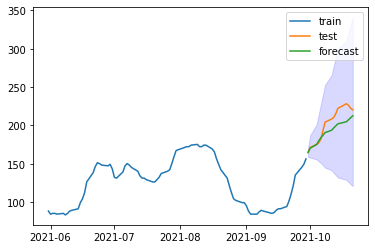

In [1014]:
fc_opt, confid_opt = model.predict(len(test),return_conf_int=True)

forecast_opt =pd.Series(fc,index=test.index)
confid_lower = pd.Series(confid[:,0],index=test.index)
confid_upper = pd.Series(confid[:,1],index=test.index)
#print(confid,confid[:,0])

plt.plot(train["students"],label="train")
plt.plot(test["students"],label="test")
plt.plot(forecast,label="forecast")
plt.fill_between(confid_lower.index, confid_lower,confid_upper,color="b",alpha=0.15)
plt.legend(loc="best")

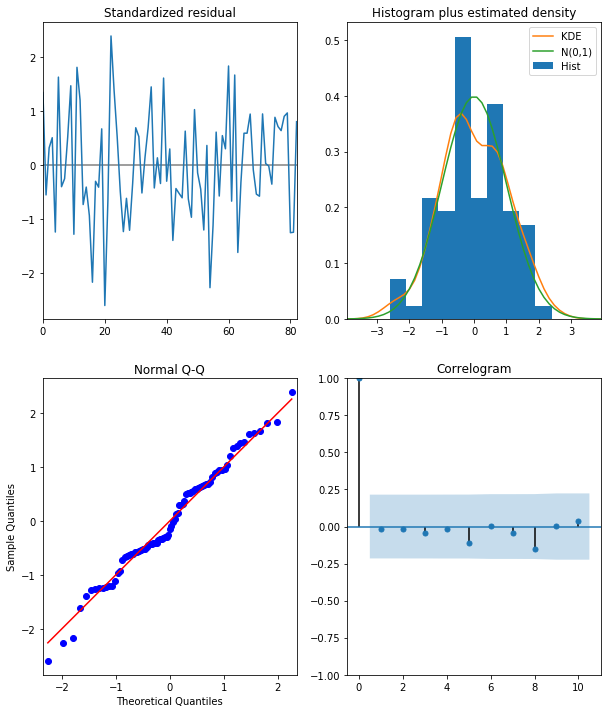

In [1015]:
model.plot_diagnostics(figsize=(10,12));

Summary of diagnostics:
-> The residuals do not show any obvious seasonality and appears to be white noise.
-> The red KDE is slightly deviated from the normal N(0,1) line. So, the residuals are not ideally normally distributed
-> The ordered distribution of residuals when compared with an standard normal distribution also show deviations again indicating the deviation from a normal distribution (not a strict requirement though)
-> The Correlogram plot shows that the residuals are not correlated with their lagged versions
    

In [1024]:
#root mean squred error

rmse_opti = sqrt(mean_squared_error(test,forecast))
rmse_opti

12.677212545415719

In [1017]:
# Calculate mean absolute percentage error

def calcmape(test, forecast):
    return 1/len(test) * np.sum(np.abs(forecast-test) / (np.abs(test) ))

mape = calcmape(test.students,forecast)
mape


0.04728151316588199

# Conclusions: 



The results described here are very similar to those obtained by running the Arima algorithm and estimating the parameters “manually”. Auto-Arima test finds the appropriate model closest to reality by evaluating AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion) and unit root for the candidate models.
However, the model/order of (p,d,q) chosen by Auto-Arima are significantly different then those chosen manually. This is due to the strict model selection criteria of Auto-Arima wherein it rejects the models that have roots even close to unity. Therefore, even if the rmse value is lower in ARIMA, it does not necessarily establishes the robustness of the model. Nonetheless, the Auto-Arima model takes the convergence of both the  Information Criterion and the numerical stability of model into account.

15